<a href="https://colab.research.google.com/github/manashpratim/Algorithms-and-Data-Structures/blob/master/Covestro_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#install library
!pip install python-resize-image

In [0]:
#Importing all the libraries
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from PIL import Image
import glob
import csv
import tensorflow as tf
from resizeimage import resizeimage
from keras.preprocessing import image
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.applications.resnet50 import ResNet50
import keras
from keras.models import load_model

In [0]:
#Function to Load Images. Returns all the images in a directory in a list format
def load_images(path):
    image_list = []
 
    for filename in glob.glob(path): 
        im=Image.open(filename)
        image_list.append([filename[::-1][:filename[::-1].find('/')][::-1],im])
    
    return image_list 

In [0]:
#Function to convert images to array. Returns a Numpy array of all the images 
def image_to_array(img_list):
    img_array = []
    for i in range(len(img_list)): 
        img_array.append(img_to_array(img_list[i][1]))

    img_array = np.array(img_array) 
    return img_array

In [0]:
#Function to extract names of images and their ratings from the.csv file. Returns a dictionary that has the files names of images and their ratings 
def parse_meta_data(path):
      rows = []
      with open(path) as csv_file:
          csv_reader = csv.reader(csv_file, delimiter=',')
          line_count = 0
          for row in csv_reader:
            if line_count == 0:
                  line_count += 1
            else:
                  rows.append(row)
      meta_data = {}
      for i in range(len(rows)):
          meta_data[rows[i][0]+'.bmp'] = rows[i][-1]     
      return meta_data

In [0]:
#Function to get the images and ratings and segregate them into x_train and y_train. 
def get_train_data(meta_data,img_list):
  ratings = []
  img_array = []
  for i in range(len(img_list)):
     ratings.append(float(meta_data[img_list[i][0]]))
     img_array.append(img_to_array(img_list[i][1]))
  ratings = np.array(ratings)
  img_array = np.array(img_array)
  return img_array,ratings

In [0]:
#Function to crop the images
def CropImage(im):

    # by finding greatest changes in gradient of average column intensity
    # in a transposed image the location of the horizontal borders can be
    # found

    window = 30 #size of the gradient over intensity space
    im = im.T 
    averageIntensity = [] #average column intensity over transposed image

    # determing average intensity of column in transposed space
    for col in range(0,len(im[0])):
        averageIntensity.append(np.mean(im[:,col]))

    # calculating gradient of intensity over all columns analyzed                  
    gradient = np.zeros(len(averageIntensity)-window)
    for i in range(0,len(averageIntensity)-window):
        gradient[i] = (averageIntensity[i+window] - averageIntensity[i])/window

    # edge is found at greatest change in intensity  
    cropCol = np.argmax(abs(gradient))
   
    # apply the crop at the edge 
    if cropCol < 200:
        im = im[:,cropCol:]
    elif cropCol > 500:
        im = im[:,0:cropCol]

    return im.T

In [0]:
#Function to resize the crop image. Returns an array of cropped images as Numpy vector
def crop_resize_image(img_list):
    img_array = []
    for i in range(len(img_list)):
        cover = CropImage(img_list[i])
        cover = array_to_img(cover)
        cover = resizeimage.resize_cover(cover, [100, 150])
        img_array.append(img_to_array(cover))  
    
    img_array = np.array(img_array)
  
    return img_array

In [0]:
#Function to resize the original image
def resize_image(img_list):
    img_array = []
    for i in range(len(img_list)):
        cover = array_to_img(img_list[i])
        cover = resizeimage.resize_cover(cover, [100, 150])
        img_array.append(img_to_array(cover))
    img_array = np.array(img_array)
 
    return img_array

In [0]:
#Function to convert one channel image to three channel image (To be used for Transfer Learning)
def one_channel_2_three_channel(img_array):
   new_array = np.zeros((img_array.shape[0],img_array.shape[1],img_array.shape[2],3))
   for i in range(len(img_array)):
      new = np.stack((img_array[i],)*3, axis=-2)
      new_array[i] = np.squeeze( new, axis=-1)
   return new_array

In [0]:
#Loading the image files and doing some preprocessing
train_image_list = load_images('/content/drive/My Drive/StudentData/train/*.bmp')
test_image_list = load_images('/content/drive/My Drive/StudentData/test/*.bmp')
train_meta_data = parse_meta_data('/content/drive/My Drive/StudentData/train_scores.csv')

x_train,y_train = get_train_data(train_meta_data,train_image_list)
x_test = image_to_array(test_image_list)

In [0]:
#cropping the images. Donot use this block if you do not want to crop the images.
train_x = crop_resize_image(x_train)
test_x = crop_resize_image(x_test)

In [0]:
#Resizing the images. Donot run this block if you ran the above (croping image) block
x_train = resize_image(x_train)
x_test = resize_image(x_test)

In [0]:
#converting one channel image to three channel images to be used later. Change the inputs to train_x and test_x if using the cropping image block
x_train_2 = one_channel_2_three_channel(train_x)
x_test_2 = one_channel_2_three_channel(test_x)

# **The Model that consistently gave us best results**

## **Transfer Learning**

In [0]:
# Implementing the model
base_model1=ResNet50(include_top=False, weights= 'imagenet', pooling='avg')

base_model1.trainable = False

x = Dense(256, activation='relu')(base_model1.output)
x = Dropout(0.4)(x)
x = Dense(1)(x)

transfer_model = Model(base_model1.input, x) 
transfer_model.compile(optimizer ='adam',
             loss = 'mean_squared_error', 
             metrics = ['mae'])

In [47]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')
history = transfer_model.fit(x_train_2, y_train, batch_size=32, epochs=50, verbose=1, callbacks=[reduce_lr], validation_split=0.05, shuffle=True,use_multiprocessing=True)

Train on 187 samples, validate on 10 samples
Epoch 1/50
187/187 [==============================] - 21s 112ms/step - loss: 12.0626 - mean_absolute_error: 2.7782 - val_loss: 17.1219 - val_mean_absolute_error: 3.1938
Epoch 2/50
187/187 [==============================] - 1s 4ms/step - loss: 3.1140 - mean_absolute_error: 1.4215 - val_loss: 51.0471 - val_mean_absolute_error: 3.6097
Epoch 3/50
187/187 [==============================] - 1s 4ms/step - loss: 2.3654 - mean_absolute_error: 1.2306 - val_loss: 19.7678 - val_mean_absolute_error: 2.8409
Epoch 4/50
187/187 [==============================] - 1s 4ms/step - loss: 2.6931 - mean_absolute_error: 1.2048 - val_loss: 25.2666 - val_mean_absolute_error: 2.6561
Epoch 5/50
187/187 [==============================] - 1s 4ms/step - loss: 2.2619 - mean_absolute_error: 1.1825 - val_loss: 2.5441 - val_mean_absolute_error: 1.1058
Epoch 6/50
187/187 [==============================] - 1s 4ms/step - loss: 1.6912 - mean_absolute_error: 1.0297 - val_loss: 0.87

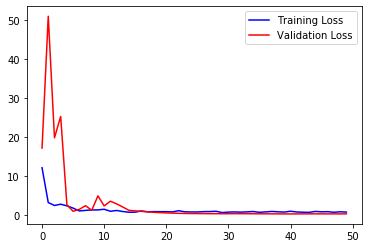

In [48]:
#Visualizing the Loss over the epochs
%matplotlib inline

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(loss)) #No. of epochs

import matplotlib.pyplot as plt
#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [0]:
test_pred = transfer_model.predict(x_test_2)

In [0]:
with open('team13submission.csv', 'w') as file:
    file.write('image,total_rating\n')
    for i in range(len(x_test)):
        file.write(str(test_image_list[i][0][:-4])+','+str(test_pred[i][0])+'\n')

In [0]:
#save the model
transfer_model.save('/content/drive/My Drive/my_model.h5') 

# **Models that we tried but did not give us best results** 

## **Simple Convolutional Neural Network**

In [21]:
# Developing the model
model1 = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,100,1)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=[3,3]),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=[3,3]),

    tf.keras.layers.Flatten(),
       
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
model1.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
model1.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1, callbacks=[reduce_lr], validation_split=0.05, shuffle=True,use_multiprocessing=True)

Train on 187 samples, validate on 10 samples
Epoch 1/50
187/187 [==============================] - 2s 11ms/sample - loss: 24.6640 - mean_absolute_error: 4.1672 - val_loss: 19.4231 - val_mean_absolute_error: 3.0189
Epoch 2/50
187/187 [==============================] - 0s 769us/sample - loss: 8.1302 - mean_absolute_error: 2.0875 - val_loss: 10.4806 - val_mean_absolute_error: 2.5819
Epoch 3/50
187/187 [==============================] - 0s 775us/sample - loss: 6.4380 - mean_absolute_error: 1.9941 - val_loss: 9.5553 - val_mean_absolute_error: 2.4235
Epoch 4/50
187/187 [==============================] - 0s 767us/sample - loss: 4.7645 - mean_absolute_error: 1.7778 - val_loss: 7.3668 - val_mean_absolute_error: 2.3308
Epoch 5/50
187/187 [==============================] - 0s 759us/sample - loss: 4.4885 - mean_absolute_error: 1.7492 - val_loss: 4.5341 - val_mean_absolute_error: 1.8512
Epoch 6/50
187/187 [==============================] - 0s 769us/sample - loss: 3.6794 - mean_absolute_error: 1.591

In [0]:
test_pred = model1.predict(x_test)

In [0]:
with open('team13submission.csv', 'w') as file:
    file.write('image,total_rating\n')
    for i in range(len(x_test)):
        file.write(str(test_image_list[i][0][:-4])+','+str(test_pred[i][0])+'\n')

##**Transfer Learning and Random Forests Regressor**

In [0]:
base_model2=ResNet50(include_top=False, weights= 'imagenet', pooling='avg')

base_model2.trainable = False

x = Dense(4096, activation='relu')(base_model2.output)

transfer_model1 = Model(base_model2.input, x) 
transfer_model1.compile(optimizer ='adam',
             loss = 'mean_squared_error', 
             metrics = ['mae'])

In [0]:
train_output = transfer_model1.predict(x_train_2)
test_output = transfer_model1.predict(x_test_2)

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators= 200)
rf.fit(train_output,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
test_pred = rf.predict(test_output )

In [0]:
with open('team13submission.csv', 'w') as file:
    file.write('image,total_rating\n')
    for i in range(len(x_test)):
        file.write(str(test_image_list[i][0][:-4])+','+str(test_pred[i])+'\n')